In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

dataset/yield_df.csv
dataset/yield.csv
dataset/pesticides.csv
dataset/rainfall.csv
dataset/temp.csv


While this notebook has the intention of been and excercise / review / first steps for our final ML project. I use the 4 original files to do my own Data-frame.

Taking acount that the files containing the information about pesticides, rainfall and temperatures are linked to a geographic zone (always country?), we're going to try to create a unique DF containing all the data attached to a geographic zone and a year.

### Working in yield

In [2]:
df_yield = pd.read_csv(dirname + "/" + filenames[1])
df_yield.head()

,Domain Code,Domain,Area Code,Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value
0,QC,Crops,2,Afghanistan,5419,Yield,56,Maize,1961,1961,hg/ha,14000
1,QC,Crops,2,Afghanistan,5419,Yield,56,Maize,1962,1962,hg/ha,14000
2,QC,Crops,2,Afghanistan,5419,Yield,56,Maize,1963,1963,hg/ha,14260
3,QC,Crops,2,Afghanistan,5419,Yield,56,Maize,1964,1964,hg/ha,14257
4,QC,Crops,2,Afghanistan,5419,Yield,56,Maize,1965,1965,hg/ha,14400


In [3]:
df_yield.Domain.describe() # unique = 1 this coloumn isn't giving us new information, we can eliminate it.
df_yield['Domain Code'].describe()# unique = 1 this coloumn isn't giving us new information, we can eliminate it.
tmp = np.where(df_yield['Year Code'] != df_yield['Year']) # This 2 columns have exactly the same info.
df_yield['Unit'].describe() # unique = 1 this coloumn isn't giving us new information, we can eliminate it.
df_yield['Element'].describe() # unique = 1 this coloumn isn't giving us new information, we can eliminate it.
df_yield['Area'].describe() #212 countries

# So, we create the new dataset putting only the meaningful data we found.
df = df_yield.loc[:,['Area','Item','Year','Value']]
df.shape

(56717, 4)

In [4]:
df_temp = pd.read_csv(dirname + "/" + filenames[4])
df_temp.columns = df_temp.columns.str.replace('year', 'Year') # I changed the
df_temp.columns = df_temp.columns.str.replace('country', 'Area')
df_temp.head()
# print(df_temp.shape[0]+df_yield.shape[0])

,Year,Area,avg_temp
0,1849,Côte D'Ivoire,25.58
1,1850,Côte D'Ivoire,25.52
2,1851,Côte D'Ivoire,25.67
3,1852,Côte D'Ivoire,NaN
4,1853,Côte D'Ivoire,NaN


In [5]:
df.Year.describe()
df = pd.merge(df, df_temp, how='inner', on = ['Year', 'Area'])
df.columns = df.columns.str.replace('Value', "yield_hg/ha")
df

,Area,Item,Year,yield_hg/ha,avg_temp
0,Afghanistan,Maize,1961,14000,14.23
1,Afghanistan,Potatoes,1961,86667,14.23
2,Afghanistan,"Rice, paddy",1961,15190,14.23
3,Afghanistan,Wheat,1961,10220,14.23
4,Afghanistan,Maize,1962,14000,14.10
...,...,...,...,...,...
84854,Zimbabwe,"Rice, paddy",2013,22581,19.76
84855,Zimbabwe,Sorghum,2013,3066,19.76
84856,Zimbabwe,Soybeans,2013,13142,19.76
84857,Zimbabwe,Sweet potatoes,2013,22222,19.76


In [6]:
print(df.isna().sum())
# I confirmed there's not NaNs ! In this case we apparently have a super good quality dataset.

Area           0
Item           0
Year           0
yield_hg/ha    0
avg_temp       0
dtype: int64


In [7]:
df_rainfall = pd.read_csv(dirname + "/" + filenames[3])
df_rainfall.columns = df_rainfall.columns.str.replace('average_rain_fall_mm_per_year', 'rain_mm_year')
df_rainfall.columns = df_rainfall.columns.str.replace(' Area', 'Area')
df_rainfall

,Area,Year,rain_mm_year
0,Afghanistan,1985,327
1,Afghanistan,1986,327
2,Afghanistan,1987,327
3,Afghanistan,1989,327
4,Afghanistan,1990,327
...,...,...,...
6722,Zimbabwe,2013,657
6723,Zimbabwe,2014,657
6724,Zimbabwe,2015,657
6725,Zimbabwe,2016,657


In [8]:
df = pd.merge(df, df_rainfall, how='inner', on = ['Year', 'Area'])
df

,Area,Item,Year,yield_hg/ha,avg_temp,rain_mm_year
0,Afghanistan,Maize,1985,16652,15.52,327
1,Afghanistan,Potatoes,1985,140909,15.52,327
2,Afghanistan,"Rice, paddy",1985,22482,15.52,327
3,Afghanistan,Wheat,1985,12277,15.52,327
4,Afghanistan,Maize,1986,16875,14.71,327
...,...,...,...,...,...,...
44130,Zimbabwe,"Rice, paddy",2013,22581,19.76,657
44131,Zimbabwe,Sorghum,2013,3066,19.76,657
44132,Zimbabwe,Soybeans,2013,13142,19.76,657
44133,Zimbabwe,Sweet potatoes,2013,22222,19.76,657


In [9]:
print(df.isna().sum())

Area            0
Item            0
Year            0
yield_hg/ha     0
avg_temp        0
rain_mm_year    0
dtype: int64


In [10]:
df_pesticides = pd.read_csv(dirname + "/" + filenames[2])
df_pesticides.head()


,Domain,Area,Element,Item,Year,Unit,Value
0,Pesticides Use,Albania,Use,Pesticides (total),1990,tonnes of active ingredients,121.0
1,Pesticides Use,Albania,Use,Pesticides (total),1991,tonnes of active ingredients,121.0
2,Pesticides Use,Albania,Use,Pesticides (total),1992,tonnes of active ingredients,121.0
3,Pesticides Use,Albania,Use,Pesticides (total),1993,tonnes of active ingredients,121.0
4,Pesticides Use,Albania,Use,Pesticides (total),1994,tonnes of active ingredients,201.0


In [11]:
df_pesticides.Item.describe() # unique = 1 this coloumn isn't giving us new information, we can eliminate it.
df_pesticides.Element.describe() # unique = 1 this coloumn isn't giving us new information, we can eliminate it.
df_pesticides.Domain.describe() # unique = 1 this coloumn isn't giving us new information, we can eliminate it.
df_pesticides.Unit.describe() # unique = 1 this coloumn isn't giving us new information, we can eliminate it.
df_pesticides.columns = df_pesticides.columns.str.replace('Value', 'ton_pest')


In [12]:
df = pd.merge(df, df_pesticides.loc[:,['Area', 'Year', 'ton_pest']], how='inner', on = ['Year', 'Area'])
print(df.isna().sum())
df

Area            0
Item            0
Year            0
yield_hg/ha     0
avg_temp        0
rain_mm_year    0
ton_pest        0
dtype: int64


,Area,Item,Year,yield_hg/ha,avg_temp,rain_mm_year,ton_pest
0,Albania,Maize,1990,36613,16.37,1485,121.00
1,Albania,Potatoes,1990,66667,16.37,1485,121.00
2,Albania,"Rice, paddy",1990,23333,16.37,1485,121.00
3,Albania,Sorghum,1990,12500,16.37,1485,121.00
4,Albania,Soybeans,1990,7000,16.37,1485,121.00
...,...,...,...,...,...,...,...
28243,Zimbabwe,"Rice, paddy",2013,22581,19.76,657,2550.07
28244,Zimbabwe,Sorghum,2013,3066,19.76,657,2550.07
28245,Zimbabwe,Soybeans,2013,13142,19.76,657,2550.07
28246,Zimbabwe,Sweet potatoes,2013,22222,19.76,657,2550.07


At this point we have a complete dataset, the ideal now is to explore this dataset using some exploratory statistics techniques to understand the dependences, correlations and patterns between attributs.

## Exploratory Analysis

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28248 entries, 0 to 28247
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Area          28248 non-null  object 
 1   Item          28248 non-null  object 
 2   Year          28248 non-null  int64  
 3   yield_hg/ha   28248 non-null  int64  
 4   avg_temp      28248 non-null  float64
 5   rain_mm_year  28248 non-null  object 
 6   ton_pest      28248 non-null  float64
dtypes: float64(2), int64(2), object(3)
memory usage: 1.5+ MB


In [14]:
# We have just to correct the dataType of rain_mm_year

# There is something that we can't not convert in float, to find it i used an easy approach with a for cycle and a try-except control structure.
for raindata in df.rain_mm_year:
    try:
        raindata = float(raindata)
    except:
        print(raindata)
        
tmp = np.where(df.rain_mm_year == '..')
df = df.drop(list(tmp[0]))
# Now we can done the correct dataType to the attribute

df.rain_mm_year = df.rain_mm_year.astype('float')
df.info()

..
..
..
..
..
..
<class 'pandas.core.frame.DataFrame'>
Index: 28242 entries, 0 to 28247
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Area          28242 non-null  object 
 1   Item          28242 non-null  object 
 2   Year          28242 non-null  int64  
 3   yield_hg/ha   28242 non-null  int64  
 4   avg_temp      28242 non-null  float64
 5   rain_mm_year  28242 non-null  float64
 6   ton_pest      28242 non-null  float64
dtypes: float64(3), int64(2), object(2)
memory usage: 1.7+ MB


In [15]:
df.Year = df.Year.astype('object')
df.describe().T

,count,mean,std,min,25%,50%,75%,max
yield_hg/ha,28242.0,77053.332094,84956.612897,50.00,19919.2500,38295.00,104676.75,501412.00
avg_temp,28242.0,20.542627,6.312051,1.30,16.7025,21.51,26.00,30.65
rain_mm_year,28242.0,1149.055980,709.812150,51.00,593.0000,1083.00,1668.00,3240.00
ton_pest,28242.0,37076.909344,59958.784665,0.04,1702.0000,17529.44,48687.88,367778.00


In [16]:
df.describe(include = 'object').T

,count,unique,top,freq
Area,28242,101,India,4048
Item,28242,10,Potatoes,4276
Year,28242,23,2012,1260


In [17]:
corr_matrix = df.loc[:,['yield_hg/ha','avg_temp','rain_mm_year', 'ton_pest']].corr()
print(corr_matrix)
# sns.heatmap(corr_matrix, annot= True , cmap='Greens')

              yield_hg/ha  avg_temp  rain_mm_year  ton_pest
yield_hg/ha      1.000000 -0.114777      0.000962  0.064085
avg_temp        -0.114777  1.000000      0.313040  0.030946
rain_mm_year     0.000962  0.313040      1.000000  0.180984
ton_pest         0.064085  0.030946      0.180984  1.000000


## Graphique


<Axes: xlabel='Year'>

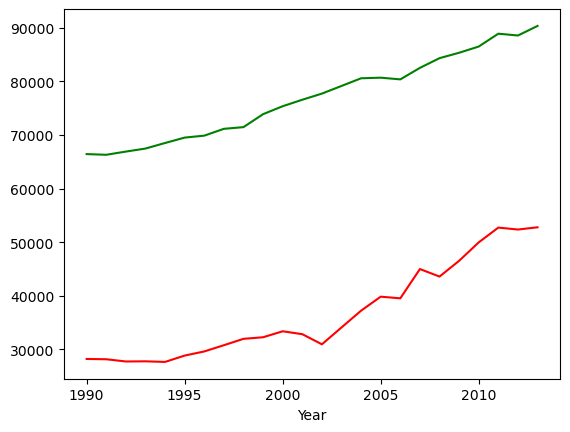

In [18]:
count_crops = df.groupby('Year')['yield_hg/ha'].mean()
count_crops.plot(color='green')

count_crops = df.groupby('Year')['ton_pest'].mean()
count_crops.plot(color='red')

## Normalization

In [19]:
cultures = df.Item.unique()
maxmin_cultures = {culture:(df.loc[df['Item'] == culture, 'yield_hg/ha'].max(), df.loc[df['Item'] == culture, 'yield_hg/ha'].min()) for culture in cultures}

yield_norm = []
for ligne in df.iterrows():
    l = ligne[1]
    n = (l['yield_hg/ha'] - maxmin_cultures[l.Item][1])/(maxmin_cultures[l.Item][0] - maxmin_cultures[l.Item][1])
    yield_norm.append(n)

df['yield_norm'] = yield_norm

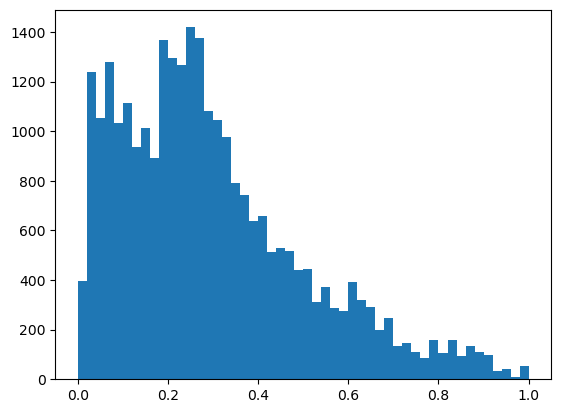

In [20]:
plt.hist(df['yield_norm'], bins=50)
plt.show()

# Dividing Data frames by Cultures

In [21]:
df_cultureGroup = df.groupby(['Item'])
df_maize = df_cultureGroup.get_group("Maize")
df_potatoes = df_cultureGroup.get_group("Potatoes")
df_rice = df_cultureGroup.get_group("Rice, paddy")
df_sorghum = df_cultureGroup.get_group("Sorghum")
df_soybeans = df_cultureGroup.get_group("Soybeans")
df_wheat = df_cultureGroup.get_group("Wheat")
df_cassava = df_cultureGroup.get_group("Cassava")
df_sweetPot = df_cultureGroup.get_group("Sweet potatoes")
df_others = df_cultureGroup.get_group("Plantains and others")
df_yams = df_cultureGroup.get_group("Yams")

In [22]:
df_parCultures = {'Maize': df_maize,
                  'Potatoes': df_potatoes,
                  'Rice, paddy': df_rice,
                  'Sorghum': df_sorghum,
                  'Soybeans': df_soybeans,
                  'Wheat': df_wheat,
                  'Cassava': df_cassava,
                  'Sweet potatoes': df_sweetPot,
                  'Plantains and others': df_others,
                  'Yams': df_yams}

In [23]:
for culture in cultures:
    print(culture,': ', df_parCultures[culture].shape)

Maize :  (4121, 8)
Potatoes :  (4276, 8)
Rice, paddy :  (3388, 8)
Sorghum :  (3039, 8)
Soybeans :  (3223, 8)
Wheat :  (3857, 8)
Cassava :  (2045, 8)
Sweet potatoes :  (2890, 8)
Plantains and others :  (556, 8)
Yams :  (847, 8)


In [24]:
X = df.loc[:,['Area', 'Item', 'Year', 'avg_temp', 'rain_mm_year', 'ton_pest']]
Y = df['yield_norm']

In [30]:
X

,avg_temp,rain_mm_year,ton_pest,Area,Item,Year
0,16.37,1485.0,121.00,Albania,Maize,1990
1,16.37,1485.0,121.00,Albania,Potatoes,1990
2,16.37,1485.0,121.00,Albania,"Rice, paddy",1990
3,16.37,1485.0,121.00,Albania,Sorghum,1990
4,16.37,1485.0,121.00,Albania,Soybeans,1990
...,...,...,...,...,...,...
28243,19.76,657.0,2550.07,Zimbabwe,"Rice, paddy",2013
28244,19.76,657.0,2550.07,Zimbabwe,Sorghum,2013
28245,19.76,657.0,2550.07,Zimbabwe,Soybeans,2013
28246,19.76,657.0,2550.07,Zimbabwe,Sweet potatoes,2013


In [29]:
# Importando as bibliotecas necessárias
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import pandas as pd

# Carregando seus dados
# df = pd.read_csv('seu_arquivo.csv')

# # Suponha que 'chuva', 'temperatura' e 'uso_pesticidas' sejam atributos numéricos e 'pais' seja categórico
atributos_numericos = ['avg_temp', 'rain_mm_year', 'ton_pest']
atributos_categoricos = ['Area', 'Item', 'Year']

# # Dividindo os dados em conjuntos de treinamento e teste
X = df[atributos_numericos + atributos_categoricos]
y = df['yield_norm']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_train=y_train.astype('int')
# print(type(X_train))
print(X_train.head())
print(y_train)

# Criando o pré-processador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), atributos_numericos),
        ('cat', OneHotEncoder(), atributos_categoricos)])

# Criando o pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', GaussianNB())])

# Treinando o modelo
clf.fit(X_train, y_train)

# Fazendo previsões
y_pred = clf.predict(X_test)

# Avaliando o modelo
mse = mean_squared_error(y_test, y_pred)
print('Erro quadrático médio: ', mse)


       avg_temp  rain_mm_year  ton_pest      Area            Item  Year
5499      25.36        1604.0    829.59  Cameroon         Sorghum  2005
10975     25.91        1083.0  70791.00     India        Soybeans  1992
2007      25.81        1292.0    484.59   Bahamas         Cassava  1997
22163     23.76         494.0  16936.00  Pakistan        Potatoes  1997
311       24.41        1010.0     40.00    Angola  Sweet potatoes  2005
5499     0
10975    0
2007     0
22163    0
311      0
        ..
21581    0
5396     0
860      0
15801    0
23660    0
Name: yield_norm, Length: 22593, dtype: int64


TypeError: A sparse matrix was passed, but dense data is required. Use X.toarray() to convert to a dense numpy array.